# Population MCMC

Population MCMC
- uses multiple chains internally, each running at a different "temperature"
- the set of temperature schedule is a hyperparameter
- is a meta-method: it uses HaarioBardenetACMC internally
- is implemented as a single chain method, at each iteration it:
  - selects chains i and j (i != j)
  - always updates chain i
  - sometimes swaps the positions of chains i and j (with some probability that makes stuff work)

As a result, we expect:
- quite a low rate of convergence on simple problems: with 10 internal chains it should be 10 times slower
- improved performance on hard problems: should deal with multi-modal distributions better
- some sensitivity to the number of temperatures used
- ...and to the exact schedule


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from plotnine import *

import pints
import pints.plot
import pints.toy
from pints.functionaltests.population import *
from utils import run_replicates, ecdf_norm_plotter

parallel = True

## Two dimensional Gaussian

In [53]:
t = pints.Timer()
test = run_replicates(
    np.geomspace(2000, 20000, 8, dtype=int), 10,
    test_population_mcmc_on_two_dim_gaussian, parallel=parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])

16.95 seconds


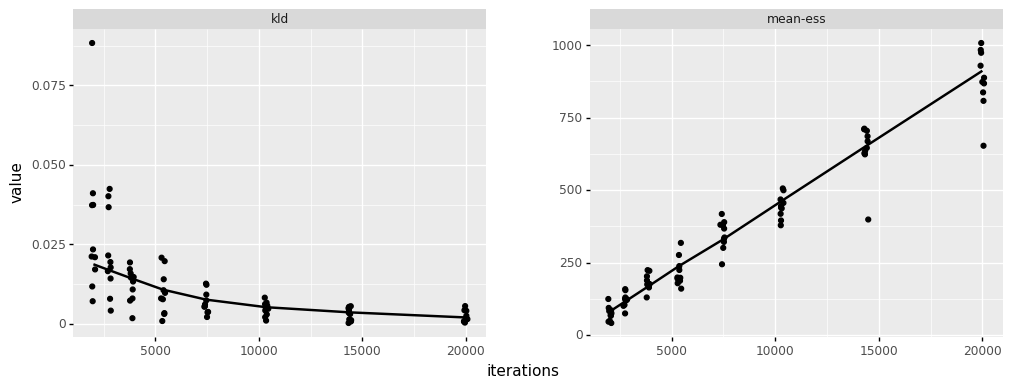

<ggplot: (8745685035268)>

In [54]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(figure_size=(12, 4), subplots_adjust={'wspace': 0.25})
)

This shows the mean ess is actually not too much lower than in the Haario-Bardenet method.
But the KLD is potentially awful. We can check this out by zooming in a bit:

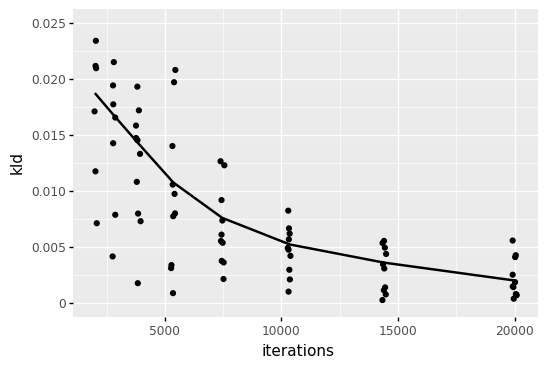

<ggplot: (8745683940732)>

In [59]:
(ggplot(test, aes(x='iterations', y='kld'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + theme(figure_size=(6, 4), subplots_adjust={'wspace': 0.25})
 + coord_cartesian(ylim=([0, 0.025]))
)

This shows that we're heading towards the kind of KLD seen in pure Haario-Bardenet MCMC, and it looks similar to what we'd expect with 10% of the iterations used there.

We can try raising the number of iterations by a factor 10 to see if this holds:

In [6]:
t = pints.Timer()
test = run_replicates(
    np.geomspace(20000, 200000, 8, dtype=int), 10,
    test_population_mcmc_on_two_dim_gaussian, parallel=parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])

5 minutes, 15 seconds


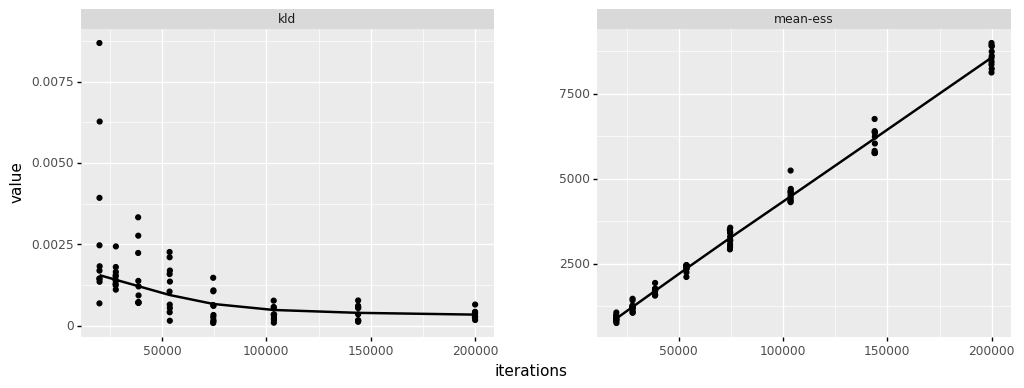

<ggplot: (8745685088476)>

In [7]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(figure_size=(12, 4), subplots_adjust={'wspace': 0.25})
)

With this 10-fold increase in the number of iterations, we see a similar KLD as in the Haario-Bardenet notebook (but a much higher ESS).

### Example run

In [8]:
n_chains = 4
n_iterations = 2000
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_parallel(parallel)
controller.set_log_to_screen(False)

chains = controller.run()

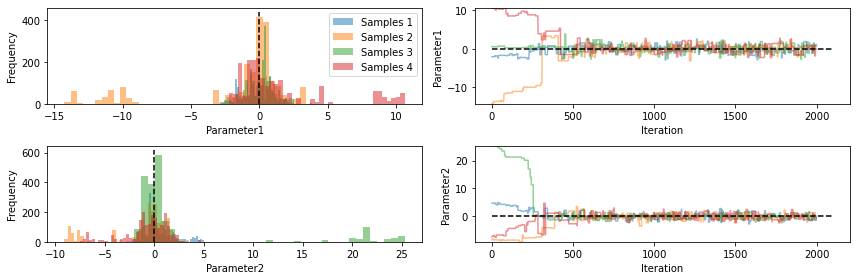

In [9]:
pints.plot.trace(chains, ref_parameters=[0, 0])
plt.show()

In [10]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  -0.04   3.10    -9.97   -0.79  0.12   0.75   8.82     1.21    131.18  24.40
param 2  0.23    4.45    -7.71   -1.03  -0.12  0.81   20.13    1.17    36.90   6.86


This shows PopulationMCMC is mixing quite slowly!

It also seems to need a bit of warm-up time:

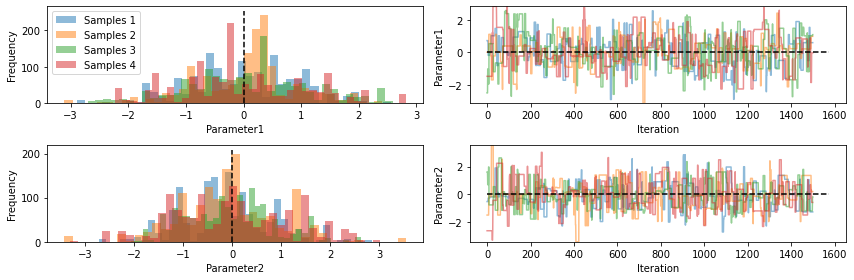

In [11]:
n_warmup = 500
pints.plot.trace(chains[:, 500:], ref_parameters=[0, 0])
plt.show()

In [12]:
results = pints.MCMCSummary(chains=chains[:, 500:], time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.04    0.99    -1.95   -0.59  0.07   0.65   2.03     1.01    338.60  62.97
param 2  -0.05   1.00    -1.79   -0.73  -0.12  0.58   1.97     1.00    399.58  74.31


In [13]:
n_chains = 4
n_iterations = 20000
n_warmup = 1000
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_parallel(parallel)
controller.set_log_to_screen(False)

chains = controller.run()
chains = chains[:, n_warmup:]

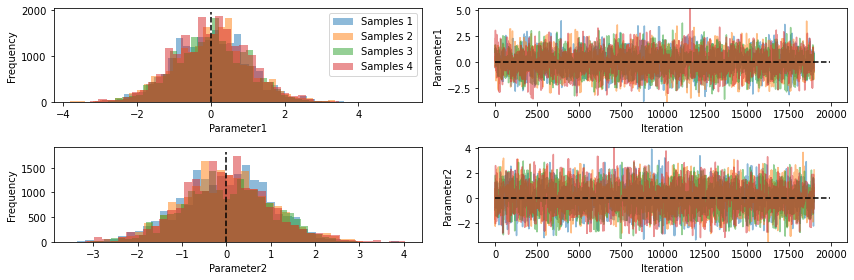

In [14]:
pints.plot.trace(chains, ref_parameters=[0, 0])
plt.show()

In [15]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  -0.00   1.01    -1.99   -0.69  0.02   0.66   1.98     1.00    3343.12  58.41
param 2  -0.01   1.00    -1.97   -0.67  -0.01  0.67   2.00     1.00    3272.69  57.18


As suggested by earlier results, with ten times more iterations it looks more like a "proper" MCMC chain.

Finally, we can plot the true against the estimated CDF:

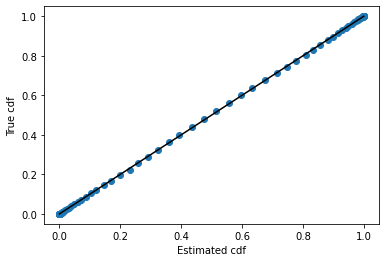

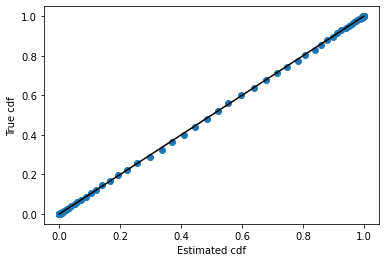

In [16]:
draws = np.vstack(chains)
for x in draws.T:
    ecdf_norm_plotter(x, 1)

## Banana

In [17]:
t = pints.Timer()
test = run_replicates(
    np.geomspace(2000, 20000, 8, dtype=int), 10,
    test_population_mcmc_on_banana, parallel=parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])

18.38 seconds


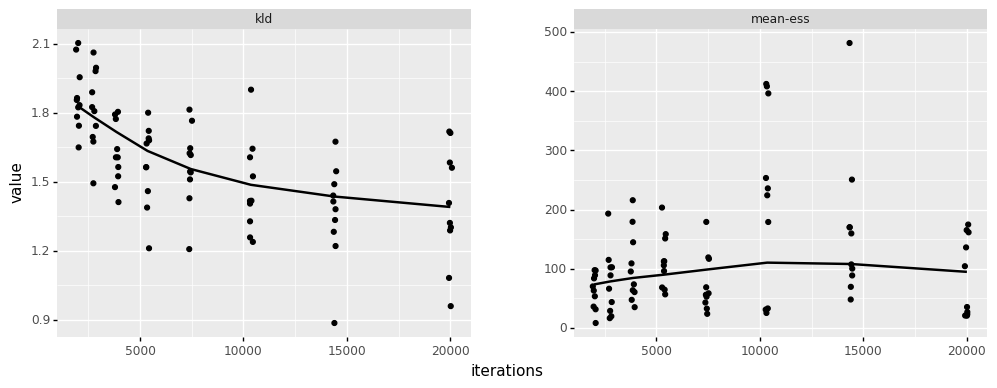

<ggplot: (8745685099969)>

In [18]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(figure_size=(12, 4), subplots_adjust={'wspace': 0.25})
)

The twisted Gaussian banana is a hard problem, but population MCMC here seems to have the advantage over the underlying Haario-Bardenet method, even at the same number of iterations.

We can try increasing the iterations to see what happens:

In [19]:
t = pints.Timer()
test = run_replicates(
    np.geomspace(20000, 100000, 8, dtype=int), 20,
    test_population_mcmc_on_banana, parallel=parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])

4 minutes, 40 seconds


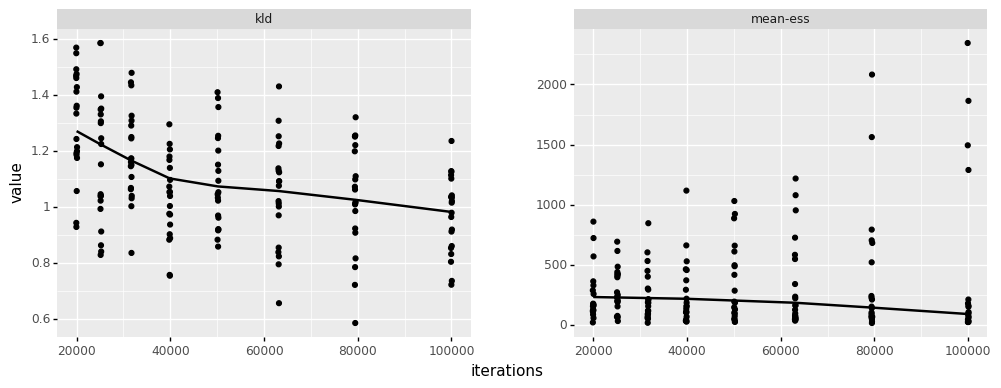

<ggplot: (8745685107288)>

In [20]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(figure_size=(12, 4), subplots_adjust={'wspace': 0.25})
)

This shows the KLD keeps going down, but the ESS is slightly more complicated, with the method occasionally performing very well.

Zooming in a bit more, a trend is still difficult to discern:

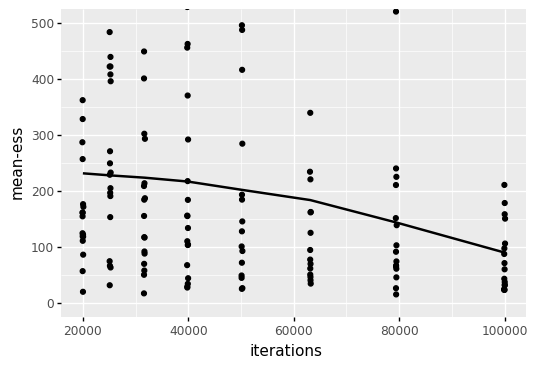

<ggplot: (8745685722465)>

In [21]:
(ggplot(test, aes(x='iterations', y='mean-ess'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + coord_cartesian(ylim=([0, 500]))
 + theme(figure_size=(6, 4), subplots_adjust={'wspace': 0.25})
)

### Example run

In [22]:
n_chains = 4
n_iterations = 100000
log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)

log_prior = pints.MultivariateGaussianLogPrior([0, 0], [[10, 0], [0, 10]])
x0 = log_prior.sample(n_chains)

sigma0 = np.diag(np.array([1, 3]))
controller = pints.MCMCController(
    log_pdf, n_chains, x0, sigma0=None, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
controller.set_parallel(parallel)

chains = controller.run()

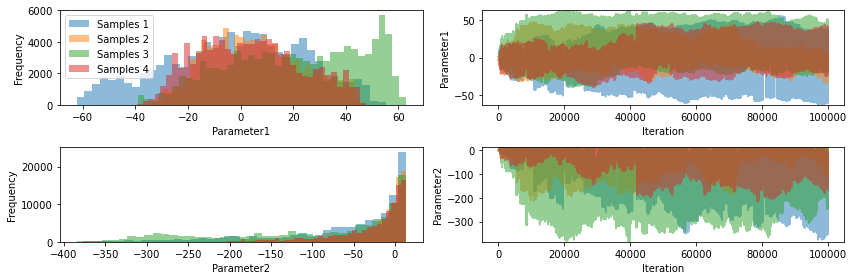

In [23]:
pints.plot.trace(chains)
plt.show()

In [24]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%     25%     50%     75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  -------  ------  ------  -----  -------  ------  ------  --------------
param 1  6.91    23.96   -39.43   -10.28  5.97    23.86  53.74    1.09    553.00  1.89
param 2  -52.22  80.14   -288.54  -75.01  -17.89  3.39   10.36    1.10    206.83  0.71


Again, it seems we need considerable warm-up

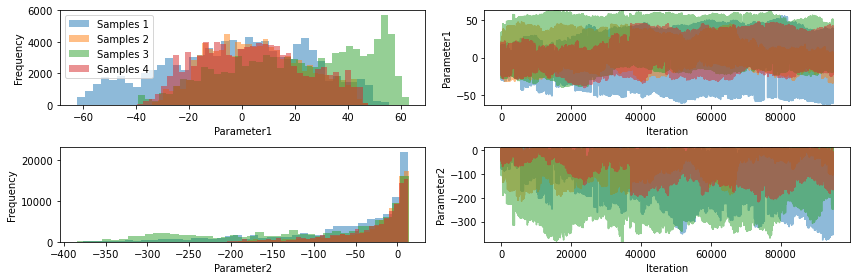

In [25]:
pints.plot.trace(chains[:, 5000:])
plt.show()

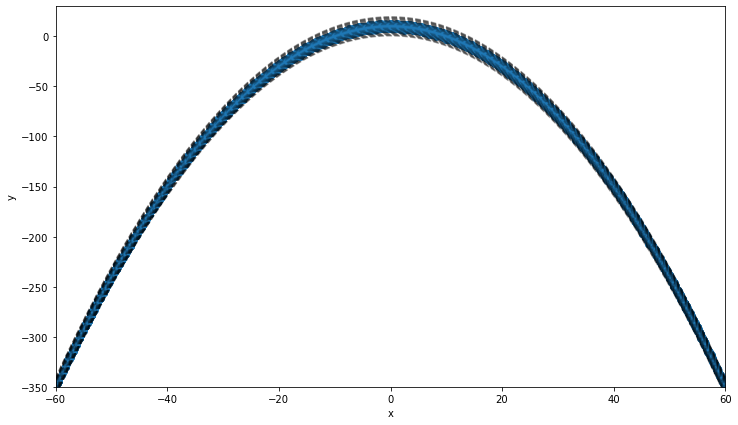

In [26]:
xlim = -60, 60
ylim = -350, 30

samples = np.vstack(chains[:, 5000:])

levels = np.linspace(-50, -1, 20)
x = np.linspace(*xlim, 250)
y = np.linspace(*ylim, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]

plt.figure(figsize=(12, 7))  
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.2)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We can also "untwist" the twisted Gaussian, and have a look at the resulting distributions:

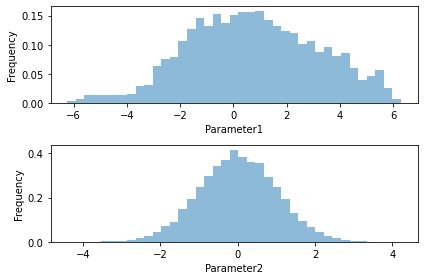

In [27]:
# Plot all samples
y = log_pdf.detransform(samples)
pints.plot.histogram([y])
plt.show()

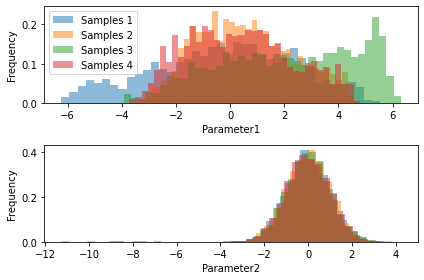

In [28]:
# Plot each chain separately
y = [log_pdf.detransform(y) for y in chains]
pints.plot.histogram(y)
plt.show()

Without doing any tests, we can see that parameter 1 is not the normal distribution we were hoping to obtain.

## Multimodal Gaussian

In [29]:
t = pints.Timer()
test = run_replicates(
    np.geomspace(2000, 20000, 8, dtype=int), 10,
    test_population_mcmc_on_multimodal_gaussian, parallel=parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])

27.09 seconds


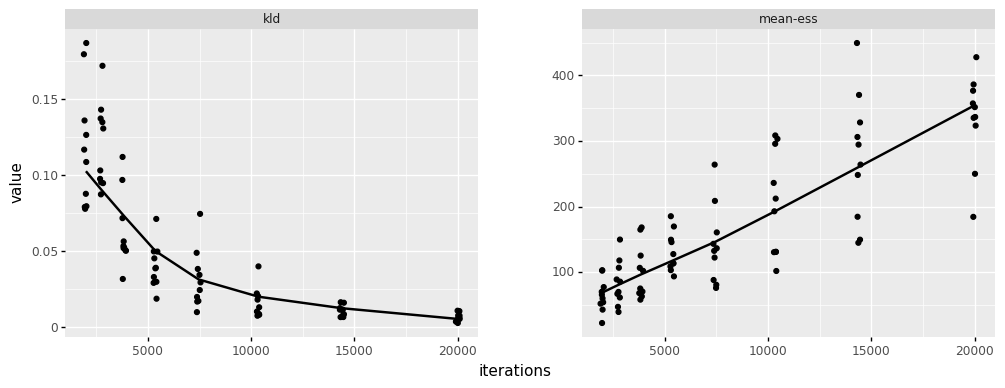

<ggplot: (8745685056007)>

In [30]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(figure_size=(12, 4), subplots_adjust={'wspace': 0.25})
)

Both lines are moving in the right direction!

### Example run

In [31]:
n_chains = 4
n_iterations = 10000

log_pdf = pints.toy.MultimodalGaussianLogPDF(
    modes=[[0, 0], [5, 10], [10, 0]],
    covariances = [[[1,  0  ], [0,    1]],
                   [[2,  0.8], [0.8,  3]],
                   [[1, -0.5], [-0.5, 1]]])
x0 = log_pdf.sample(n_chains)

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
controller.set_parallel(parallel)

chains = controller.run()

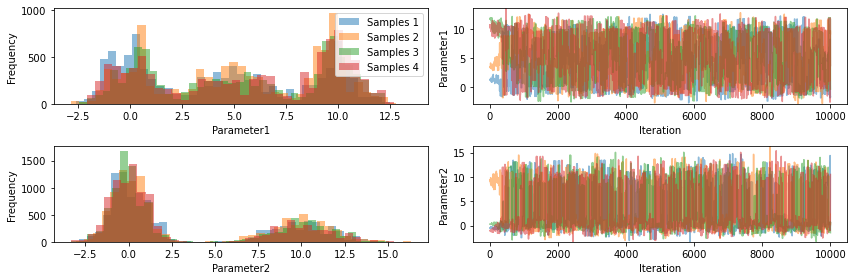

In [32]:
pints.plot.trace(chains)
plt.show()

In [33]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  5.12    4.25    -1.31   0.71   5.11   9.45   11.45    1.02    488.61  15.67
param 2  3.21    4.85    -1.65   -0.38  0.61   8.70   12.54    1.00    768.42  24.64


The plot is consistent with modes at (0, 0), (5, 10), and (10, 0).
The chains seem to be mixing (slowly, again).
Crucially, each chain has found each mode.
As before the ESS per second isn't great, but overal this method performs well here.

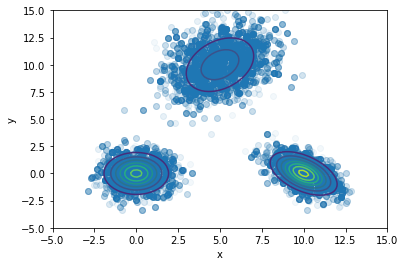

In [34]:
samples = np.vstack(chains[:, 500:])

num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1], alpha=0.05)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Hyperparameters

We can try to have a look at the effects of the temperature schedule with this problem:

In [36]:
n_temperatures = 2
n_chains = 1
n_warmup = 500
n_iterations = 10000
x0 = log_pdf.sample(1)

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_temperature_schedule(n_temperatures)

chains = controller.run()
chains = chains[:, 500:]

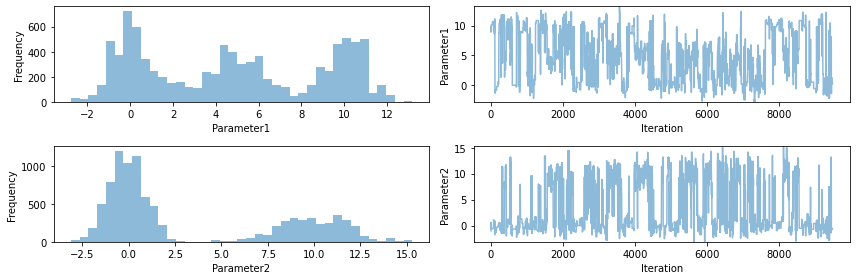

In [37]:
pints.plot.trace(chains)
plt.show()

In [38]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
param 1  4.79    4.23    -1.19   0.47   4.64   9.27   11.32    1.04    42.89  16.69
param 2  3.36    4.98    -1.78   -0.50  0.56   8.73   12.36    1.00    81.19  31.59


/home/michael/dev/pints/pints/_mcmc/_summary.py:54: UserWarning: Summaries calculated with one chain may be unreliable. It is recommended that you rerun sampling with more than one chain.


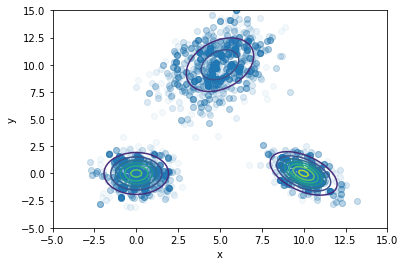

In [39]:
samples = np.vstack(chains[:, 500:])

plt.figure()
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1], alpha=0.05)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Even with just two temperatures this seems to work OK!

The chains spend longer at each mode, so they don't "mix" in the whole parameter space as much. But each chain gets lots more time now, so it doesn't look as bad as the 10-temperature exploration of the single Gaussian.

In [40]:
n_temperatures = 5
n_chains = 1
n_warmup = 500
n_iterations = 10000

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_temperature_schedule(n_temperatures)

chains = controller.run()
chains = chains[:, 500:]

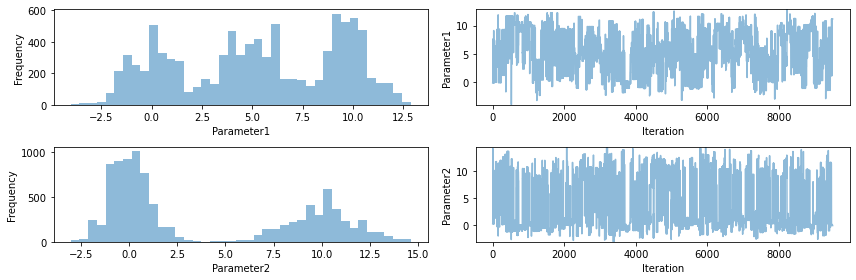

In [41]:
pints.plot.trace(chains)
plt.show()

In [42]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  5.27    4.05    -1.49   1.37   5.29   9.21   11.49    1.00    103.94  38.64
param 2  3.94    5.05    -1.75   -0.13  0.94   9.44   12.60    1.00    210.54  78.28


/home/michael/dev/pints/pints/_mcmc/_summary.py:54: UserWarning: Summaries calculated with one chain may be unreliable. It is recommended that you rerun sampling with more than one chain.


With 5 temperatures we see a lot more switching between modes, and the ess goes up.

In [43]:
n_temperatures = 10
n_chains = 1
n_warmup = 500
n_iterations = 10000

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_temperature_schedule(n_temperatures)

chains = controller.run()
chains = chains[:, 500:]

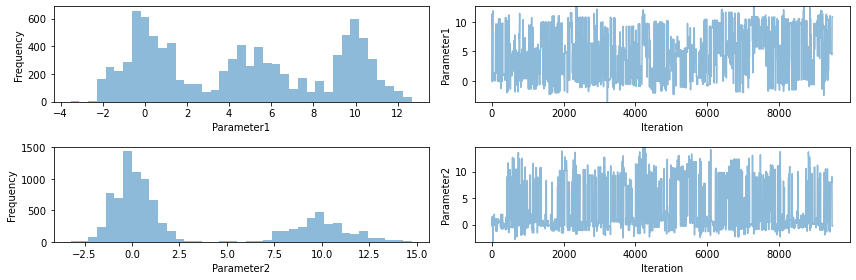

In [44]:
pints.plot.trace(chains)
plt.show()

In [45]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  4.57    4.30    -1.79   0.35   4.68   9.22   11.36    1.03    122.72  45.98
param 2  3.10    4.71    -1.54   -0.28  0.62   8.61   12.31    1.00    147.12  55.13


/home/michael/dev/pints/pints/_mcmc/_summary.py:54: UserWarning: Summaries calculated with one chain may be unreliable. It is recommended that you rerun sampling with more than one chain.


10 Doesn't seem to make that much difference. We can try a higher number still:

In [46]:
n_temperatures = 20
n_chains = 1
n_warmup = 500
n_iterations = 10000

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_temperature_schedule(n_temperatures)

chains = controller.run()
chains = chains[:, 500:]

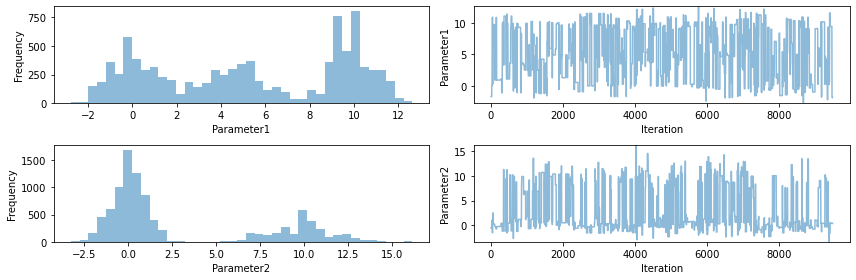

In [47]:
pints.plot.trace(chains)
plt.show()

In [48]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  5.26    4.31    -1.57   0.90   4.99   9.66   11.48    1.00    259.84  95.20
param 2  2.88    4.65    -1.62   -0.27  0.53   8.02   12.33    1.00    159.38  58.39


/home/michael/dev/pints/pints/_mcmc/_summary.py:54: UserWarning: Summaries calculated with one chain may be unreliable. It is recommended that you rerun sampling with more than one chain.


### Hyperparameters: A bit more structured

We can take a more structure approach and try writing a "run_replicates" for the hyperparameters:

In [49]:
def explore(temperatures, iterations, n_replicates, test, parallel=False):
    """
    Runs ``test(i)`` for all entries ``n`` in ``temperatures``, using a fixed
    number of ``iterations``, and running each test ``n_replicates`` times.

    The argument ``test`` is expected to be a function testing population MCMC.

    The returned value is a pandas DataFrame with 
    ``len(temperatures) * n_replicates`` rows. Each column contains an index,
    the number of temperatures as ``temperatures``, the  index of the repeat as
    ``replicate``, followed by the entries of the corresponding test result.

    Parallel evaluation can be enabled by setting ``parallel`` to ``True`` or
    to the number of worker processes to use. However, this can cause issues in
    Jupyter notebooks.
    """
    df = pd.DataFrame(index=np.arange(len(temperatures) * n_replicates))
    df['temperatures'] = np.repeat(temperatures, n_replicates)
    df['replicate'] = np.tile(np.arange(n_replicates), len(temperatures))
    
    def run(temperatures):
        return test(iterations, temperatures)

    results = pints.evaluate(run, list(df['temperatures']), parallel=parallel)
    assert len(results) > 0, 'Empty result set generated'
    for key in results[0].keys():
        df[key] = np.array([r[key] for r in results], copy=False)

    return df

In [50]:
t = pints.Timer()
test = explore(
    np.arange(2, 20, 2), 20000, 20,
    test_population_mcmc_on_multimodal_gaussian, parallel=parallel)
print(t.format())

2 minutes, 31 seconds


In [51]:
df = pd.melt(test, id_vars=['temperatures', 'replicate'])

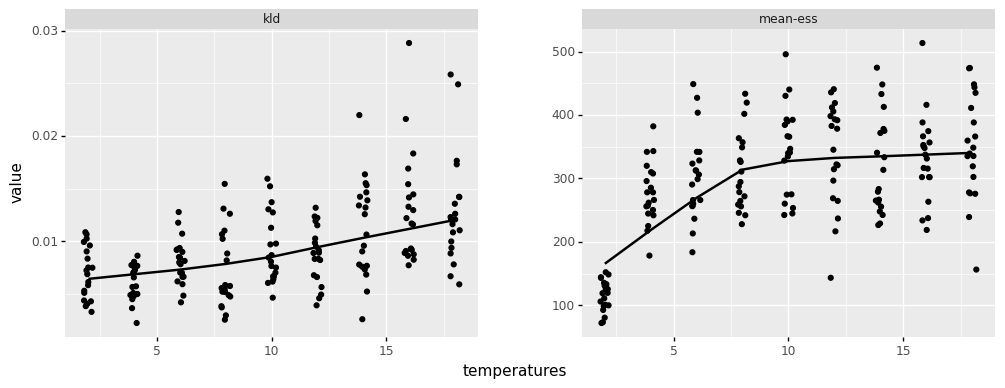

<ggplot: (8745685048074)>

In [52]:
(ggplot(df, aes(x='temperatures', y='value'))
 + geom_jitter(width=0.2)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(figure_size=(12, 4), subplots_adjust={'wspace': 0.25})
)

The KLD plot shows a decrease as the number of temperatures increases. This _might_ expected: as only one internal chain is updated per iteration, the number of iterations per chain goes down as the number of temperatures goes up.
However, the number of switches from chain to chain goes up, so we might also expect an increase in "big mixing" that compensates for the loss of "small mixing" near each mode.
This does not seem to be the case here.

The ESS plot shows an increase in ESS with more temperatures.
Most prominently, a big jump when we go from 2 to 3 temperatures.
The smoothed line seems to want to hide this a bit